###### General Steps to Follow
1. Importing Packages
1. Setup Mediapipe
1. Counting Based on Some Thresholds
1. Counting Based Change in Angle (Increasing/Decreasing)

# ------------------------------------------------------------------------------------------------------------

## 1) Importing Packages

In [10]:
import os
import sys
REPO_DIR_PATH = os.path.normpath(os.path.join(
    os.path.join(os.getcwd(), "..")))
sys.path.append(REPO_DIR_PATH)

In [11]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from src.data_preprocessing.data_transformation import DataTransformer
from scipy.signal import medfilt
from scipy.signal import find_peaks

# ------------------------------------------------------------------------------------------------------------

## 2) Setup Mediapipe

In [12]:
# Setup mediapipe instance
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

In [13]:
pose_model = mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)

I0000 00:00:1712319955.217345    6324 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1712319955.259735    7358 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.161.07), renderer: NVIDIA GeForce GTX 1650/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


###                                                              MediaPipe Poses
<img src="https://i.imgur.com/3j8BPdc.png" style="height:300px" >

# ------------------------------------------------------------------------------------------------------------

## 3) Counting Based on Some Thresholds

In [14]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle

In [33]:
cap = cv2.VideoCapture(0)
#cap = cv2.VideoCapture("/media/amro/944A72844A726342/E-JUST/Mine/Year3/S1/Seminar/Datasets/archive/Original Datasets/Bicep Curl/b1/b1_bicepcurl_1.mp4")

# Curl counter variables
counter = 0 
stage = None
angles = []
## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
            wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
            
            # Calculate angle
            angle = calculate_angle(shoulder, elbow, wrist)
            angles.append(angle)
            
            # Visualize angle
            cv2.putText(image, str(angle), 
                           tuple(np.multiply(elbow, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
            
            # Curl counter logic
            if angle > 160:
                stage = "down"
            if angle < 50 and stage =='down':
                stage="up"
                counter +=1
                       
        except:
            pass
        
        # Render curl counter
        # Setup status box
        cv2.rectangle(image, (0,0), (225,73), (245,117,16), -1)
        
        # Rep data
        cv2.putText(image, 'REPS', (15,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(counter), 
                    (10,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        
        # Stage data
        cv2.putText(image, 'STAGE', (65,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, stage, 
                    (60,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

I0000 00:00:1711488139.277160    8466 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1711488139.307843    9374 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.161.07), renderer: NVIDIA GeForce GTX 1650/PCIe/SSE2


#### Plotting Angles Over Frames

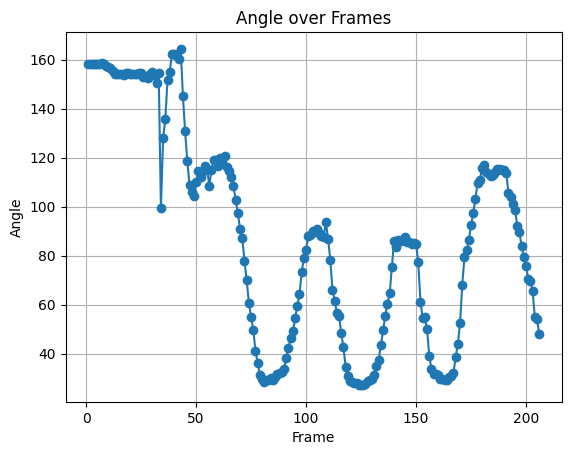

In [34]:
frames = []
for i in range(1,len(angles)+1):
    frames.append(i)
plt.plot(frames, angles, marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Frame')
plt.ylabel('Angle')
plt.title('Angle over Frames')

# Show grid
plt.grid(True)

# Show plot
plt.show()

#### Applying Median Filter

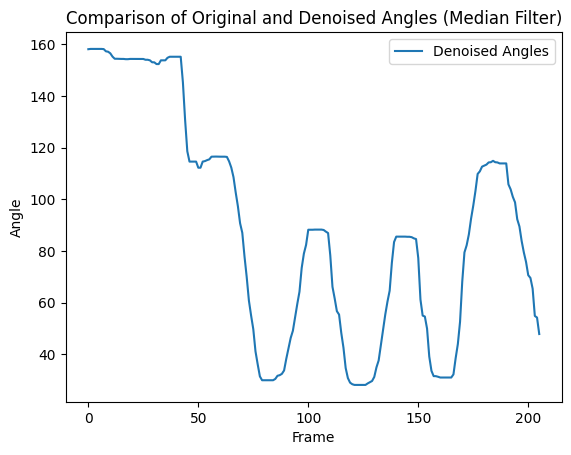

In [35]:
# Assuming 'angles_series' is the pandas Series containing angles over frames

# Define the window size for the median filter (adjust as needed)
window_size = 11

# Apply median filter to the angles_series
denoised_angles = medfilt(angles, kernel_size=window_size)

# Plot the original and denoised angles
#plt.plot(angles, label='Original Angles')
plt.plot(denoised_angles, label='Denoised Angles')

# Set labels and title
plt.xlabel('Frame')
plt.ylabel('Angle')
plt.title('Comparison of Original and Denoised Angles (Median Filter)')
plt.legend()

# Show plot
plt.show()


In [28]:
# for angle in denoised_angles:
#     print(angle)

# ------------------------------------------------------------------------------------------------------------

## 4) Counting Based Change in Angle (Increasing/Decreasing)

In [15]:
cap = cv2.VideoCapture(0)
#cap = cv2.VideoCapture("/media/amro/944A72844A726342/E-JUST/Mine/Year3/S1/Seminar/Datasets/archive/Original Datasets/Bicep Curl/b1/b1_bicepcurl_1.mp4")

# Curl counter variables
counter = 0 
previous_angle = None
increasing = None
decreasing = False
angles = []
## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
            wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
            
            # Calculate angle
            angle = calculate_angle(shoulder, elbow, wrist)
            angles.append(angle)
            
            # Visualize angle
            cv2.putText(image, str(angle), 
                           tuple(np.multiply(elbow, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
            
            # Curl counter logic based on angle change
            if previous_angle is not None:
                if angle > previous_angle:
                    if decreasing:
                        counter += 1
                        decreasing = False
                    increasing = True
                elif angle < previous_angle:
                    if increasing:
                        decreasing = True
                    increasing = False
            previous_angle = angle
        except:
            pass
        
        # Render curl counter
        # Setup status box
        cv2.rectangle(image, (0,0), (225,73), (245,117,16), -1)
        
        # Rep data
        cv2.putText(image, 'REPS', (15,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(counter), 
                    (10,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )   
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


I0000 00:00:1712319987.149417    6324 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1712319987.172000    7375 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.161.07), renderer: NVIDIA GeForce GTX 1650/PCIe/SSE2


#### Plotting Angles Over Frames

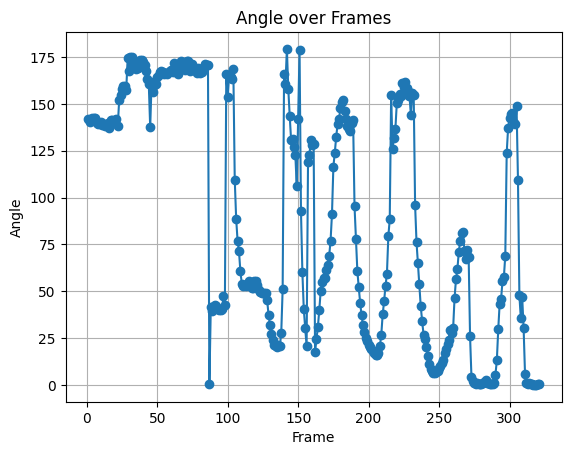

In [16]:
frames = []
for i in range(1,len(angles)+1):
    frames.append(i)
plt.plot(frames, angles, marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Frame')
plt.ylabel('Angle')
plt.title('Angle over Frames')

# Show grid
plt.grid(True)

# Show plot
plt.show()

#### Applying Median Filter

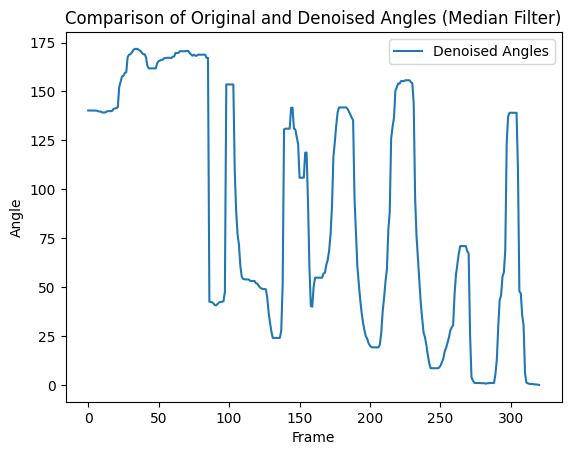

In [17]:
# Assuming 'angles_series' is the pandas Series containing angles over frames

# Define the window size for the median filter (adjust as needed)
window_size = 11

# Apply median filter to the angles_series
denoised_angles = medfilt(angles, kernel_size=window_size)

# Plot the original and denoised angles
#plt.plot(angles, label='Original Angles')
plt.plot(denoised_angles, label='Denoised Angles')

# Set labels and title
plt.xlabel('Frame')
plt.ylabel('Angle')
plt.title('Comparison of Original and Denoised Angles (Median Filter)')
plt.legend()

# Show plot
plt.show()


In [18]:
# Assuming 'angles_series' is the pandas Series containing angles over frames

# Find peaks and troughs in the angle data
peaks, _ = find_peaks(denoised_angles, prominence=0.1)  # Adjust prominence threshold as needed
troughs, _ = find_peaks(-denoised_angles, prominence=0.1)  # Find troughs by negating the angle data

# The number of cycles is half the number of peaks or troughs, as each cycle has both a peak and a trough
num_cycles = min(len(peaks), len(troughs)) // 2

print("Number of cycles:", num_cycles)

Number of cycles: 6


In [63]:
peaks,denoised_angles[peaks]

(array([  4,  18,  60,  85, 126, 168, 194, 210, 245]),
 array([  9.41969855,   4.62081928, 134.38345621, 123.30410856,
        134.91624662, 118.12228475, 103.32656677, 102.10675089,
        113.79692137]))

In [64]:
troughs,denoised_angles[troughs]

(array([ 16,  19,  75, 100, 143, 181, 200, 231, 256]),
 array([  4.34193405,   4.34193405, 119.42116496,  62.93656012,
         74.77454191,  75.08328581,  91.19108488,  28.92471213,
         13.85361559]))

#### Plotting Peaks and Troughs

Text(0.5, 1.0, 'Angles Series with Peaks and Troughs')

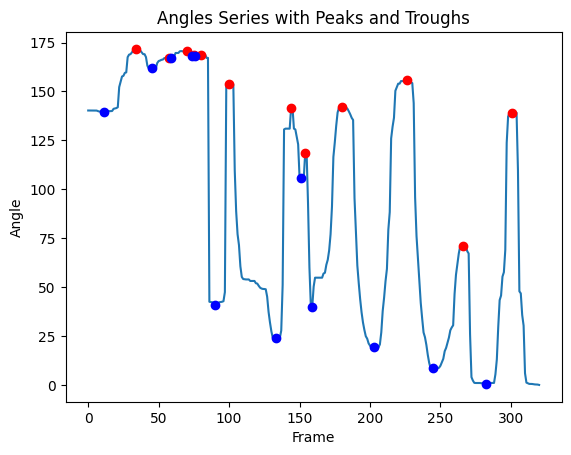

In [19]:
# Plot the angle series
plt.plot(denoised_angles, label='Angle Series')

# Plot peaks and troughs
plt.plot(peaks, denoised_angles[peaks], 'ro', label='Peaks')
plt.plot(troughs, denoised_angles[troughs], 'bo', label='Troughs')

# Set labels and title
plt.xlabel('Frame')
plt.ylabel('Angle')
plt.title('Angles Series with Peaks and Troughs')

In [3]:
import os

In [8]:
x = os.path.normpath(os.path.join(
    os.path.join(os.getcwd(), "..")))

In [9]:
x

'/media/amro/944A72844A726342/E-JUST/Mine/Year3/S1/Seminar/repo'